In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from statsmodels.stats import multitest
from scipy import stats
import collections
import itertools
import os

# Correlating spliz gene/ontology effect sizes to SRRS peripheral

In [2]:
#Pull directly from gene_cell table because I want to collapse per mouse (2 mice total)
mop_df = pd.read_csv('../outputs/gene_cell/MOp_peripheral_ReadZs_gene_ontology.csv')

gb_cols = ['mouse','gene','ontology']

#filter SRRS results to
#1. Drop gene/cells which have fewer than 5 gene spots of interest
#2. Drop gene/cell-type/mouse with fewer than 20 cells
mop_df = mop_df[mop_df['num_gene_spots'].ge(5)]
mop_df = mop_df.groupby(gb_cols).filter(lambda g: len(g) >= 20)

#aggregate by mouse (over all slices)
#Calculate z from Lyapunov CLT for each gene in each sample
mop_agg_df = mop_df.groupby(gb_cols).agg(
    num_cells = ('cell_id','nunique'),
    num_slices = ('sample','nunique'),
    med_gene_spots = ('num_gene_spots','median'),
    med_spots = ('num_spots','median'),
    med_score = ('score','median'),
    score_sum = ('score','sum'),
    var_sum = ('variance','sum'),
).reset_index()

mop_agg_df['z'] = mop_agg_df['score_sum']/np.sqrt(mop_agg_df['var_sum'])

#Calculate two-sided p and BH correct ps
p_onesided = stats.norm.cdf(mop_agg_df['z'])
mop_agg_df['p'] = 2*np.minimum(p_onesided, 1-p_onesided)

alpha = 0.05

_,adj_p,_,_ = multitest.multipletests(
    mop_agg_df['p'],
    alpha = alpha,
    method = 'fdr_bh',
)
mop_agg_df['bh_p'] = adj_p
mop_agg_df = mop_agg_df.rename(columns={'mouse':'merfish_mouse'})
mop_agg_df

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p
0,1,Acta2,L2/3 IT,991,5,5.0,695.0,0.102431,91.602118,122.242160,8.285048,2.220446e-16,8.804734e-16
1,1,Acta2,L5 ET,106,3,5.0,888.5,0.095434,9.724163,13.084333,2.688292,7.181856e-03,1.179307e-02
2,1,Acta2,L5 IT,817,5,6.0,836.0,0.125850,92.051336,97.079655,9.342562,0.000000e+00,0.000000e+00
3,1,Acta2,L6 CT,265,3,5.0,516.0,0.176113,39.580953,33.029954,6.887035,5.696776e-12,1.891902e-11
4,1,Acta2,L6 IT,448,5,5.0,781.5,0.167048,69.549196,54.999854,9.378024,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2509,2,Wnt7b,L5 ET,562,6,10.0,869.0,0.054671,25.664760,46.654497,3.757426,1.716700e-04,3.422509e-04
2510,2,Wnt7b,L5 IT,4906,6,18.0,636.0,0.052561,252.284730,275.239351,15.206725,0.000000e+00,0.000000e+00
2511,2,Wnt7b,L6 CT,1684,6,8.0,435.0,0.077132,111.832298,155.319639,8.973339,0.000000e+00,0.000000e+00
2512,2,Wnt7b,L6 IT,1053,6,8.0,661.0,0.083333,82.884489,97.084564,8.411979,0.000000e+00,0.000000e+00


In [149]:
spliz_df = pd.read_csv('../outputs/spliz/spliz_merf_genes_eff_sizes.csv')
spliz_df = spliz_df[spliz_df['num_spliz_cells'].ge(10)] #Note, filtering out gene/ont/mice with fewer than 10 cells
spliz_df.head()

,gene,ontology,median_scZ,num_spliz_cells,mouse
2,Cbln2,L2/3 IT,0.037889,219,457911
3,Cbln2,L5 IT,0.089692,254,457911
4,Cbln2,L5/6 NP,0.065126,44,457911
5,Cbln2,L6 CT,0.194901,123,457911
6,Cbln2,L6 IT,-0.012343,60,457911


Wide-form Spliz table


mouse             426003    427378    457909    457911
gene  ontology                                        
Ano4  Vip      -0.418066       NaN       NaN       NaN
Cbln2 L2/3 IT   0.086415 -0.008119 -0.015543  0.037889
      L5 IT     0.086415  0.109316  0.041700  0.089692
      L5/6 NP   0.190282  0.109316  0.223473  0.065126
      L6 CT     0.009668  0.109316  0.096098  0.194901

Median scZ scores between mice for gene/ontologies are not generally well-correlated


mouse,426003,427378,457909,457911
mouse,,,,
426003,1.000000,0.325389,-0.283925,-0.139190
427378,0.325389,1.000000,0.791472,0.053843
457909,-0.283925,0.791472,1.000000,-0.029577
457911,-0.139190,0.053843,-0.029577,1.000000


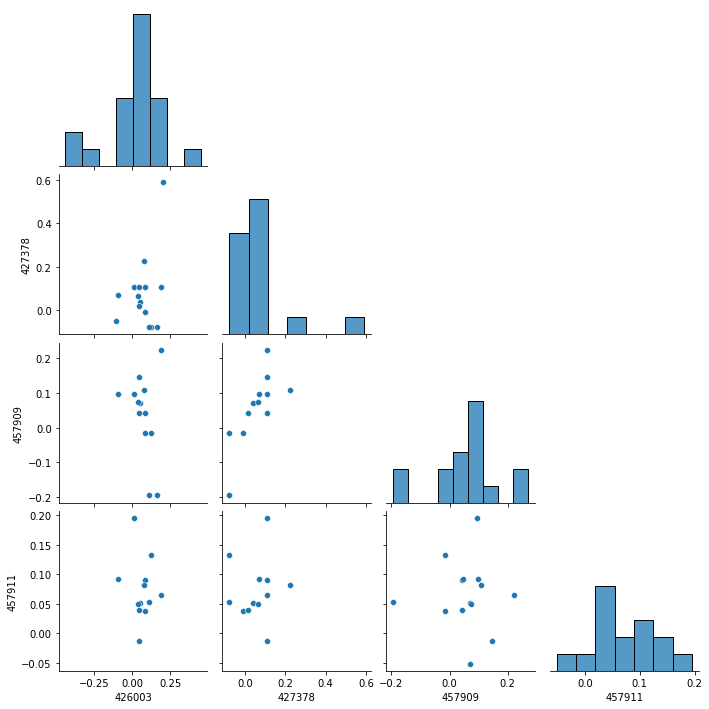

In [150]:
#Testing if Spliz gene/ontology median scZ values are correlated across different mice
wide_df = spliz_df.pivot(
    index = ['gene','ontology'],
    columns = 'mouse',
    values = 'median_scZ'
)
print('Wide-form Spliz table')
display(wide_df.head())

print('Median scZ scores between mice for gene/ontologies are not generally well-correlated')
display(wide_df.corr())

sns.pairplot(
    wide_df,
    corner = True,
)
plt.show()
plt.close()

In [151]:
#merge the SRRS and ReadZs
m = mop_agg_df.merge(spliz_df, on=['gene','ontology'])
m.head()

,merfish_mouse,gene,ontology,num_cells,num_slices,med_gene_spots,med_spots,med_score,score_sum,var_sum,z,p,bh_p,median_scZ,num_spliz_cells,mouse
0,1,Ano4,Vip,128,4,8.0,438.0,-0.238703,-26.432475,12.092378,-7.601197,2.934047e-14,1.102570e-13,-0.418066,10,426003
1,2,Ano4,Vip,52,2,8.0,445.0,-0.192256,-9.109225,4.997744,-4.074688,4.607600e-05,9.685207e-05,-0.418066,10,426003
2,1,Cbln2,L2/3 IT,10795,6,11.0,542.0,0.048729,453.616415,819.675576,15.844107,0.000000e+00,0.000000e+00,0.037889,219,457911
3,1,Cbln2,L2/3 IT,10795,6,11.0,542.0,0.048729,453.616415,819.675576,15.844107,0.000000e+00,0.000000e+00,-0.008119,307,427378
4,1,Cbln2,L2/3 IT,10795,6,11.0,542.0,0.048729,453.616415,819.675576,15.844107,0.000000e+00,0.000000e+00,-0.015543,349,457909


In [159]:
#calculate pearson correlations and BH corrected p-values
corr_data = collections.defaultdict(list)

#don't correlate ReadZs/SRRS gene/samples/mice with too few ontologies
gene_sample_ontology_df = (
    m.groupby([
        'gene',
        'merfish_mouse',
        'mouse'
    ]).filter(
        lambda g: g['ontology'].nunique() >= 2)
)

for (gene,merfish_mouse,spliz_mouse),g in gene_sample_ontology_df.groupby(['gene','merfish_mouse','mouse']):
    r,p = stats.pearsonr(g['med_score'],g['median_scZ'])
    
    corr_data['gene'].append(gene)
    corr_data['merfish_mouse'].append(merfish_mouse)
    corr_data['spliz_mouse'].append(spliz_mouse)
    corr_data['num_celltypes'].append(g['ontology'].nunique())
    corr_data['med_SRRS_cells_per_celltype'].append(g['num_cells'].median())
    corr_data['med_spliz_cells_per_celltype'].append(g['num_spliz_cells'].median())
    corr_data['pearson_r'].append(r)
    corr_data['pearson_p'].append(p)

#BH multiple hypothesis correction for correlation p-values
corr_df = pd.DataFrame(corr_data).sort_values('pearson_p').dropna()

_,adj_p,_,_ = multitest.multipletests(
    corr_df['pearson_p'],
    alpha = 0.05,
    method = 'fdr_bh',
)

corr_df['bh_pearson_p'] = adj_p
corr_df['significant'] = corr_df['bh_pearson_p'].le(0.05)

corr_df

/home/users/rbierman/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,gene,merfish_mouse,spliz_mouse,num_celltypes,med_SRRS_cells_per_celltype,med_spliz_cells_per_celltype,pearson_r,pearson_p,bh_pearson_p,significant
23,Tox,1,457911,3,4302.0,13.0,-0.999963,0.005448,0.141650,False
16,Cxcl14,2,457909,3,214.0,80.0,0.996787,0.051050,0.663653,False
17,Cxcl14,2,457911,3,214.0,54.0,0.985273,0.109391,0.751788,False
11,Cxcl14,1,427378,3,435.0,73.0,0.983542,0.115660,0.751788,False
4,Cbln2,2,426003,6,2165.0,109.0,0.657699,0.155701,0.781198,False
12,Cxcl14,1,457909,3,435.0,80.0,0.948199,0.205805,0.781198,False
22,Tox,1,457909,4,2660.5,25.0,-0.748294,0.251706,0.781198,False
13,Cxcl14,1,457911,3,435.0,54.0,0.915149,0.264146,0.781198,False
15,Cxcl14,2,427378,3,214.0,73.0,0.911135,0.270415,0.781198,False
27,Tox,2,457911,3,3888.0,13.0,-0.885592,0.307507,0.799517,False


In [167]:
corr_df['gene'].unique()

array(['Tox', 'Cxcl14', 'Cbln2', 'Rgs6', 'Cdh12'], dtype=object)

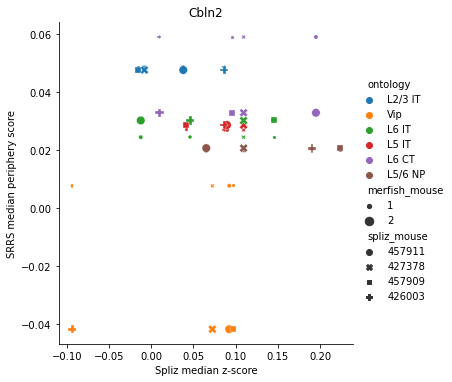

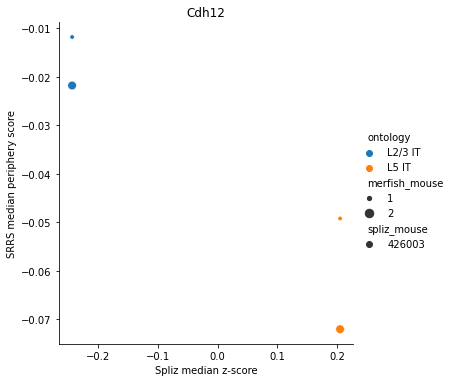

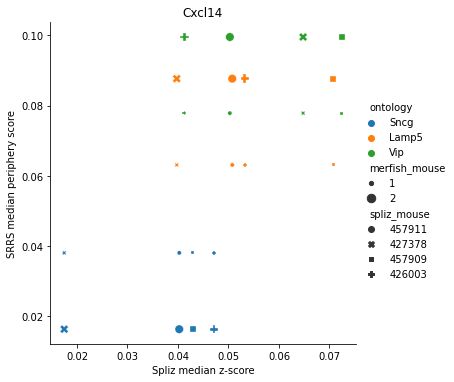

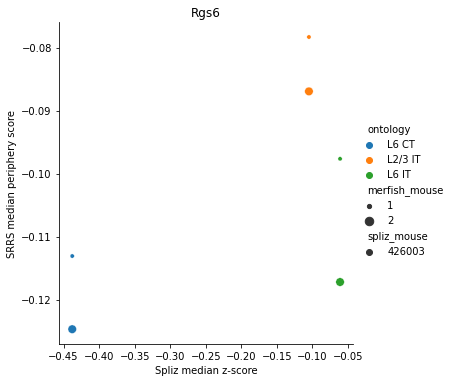

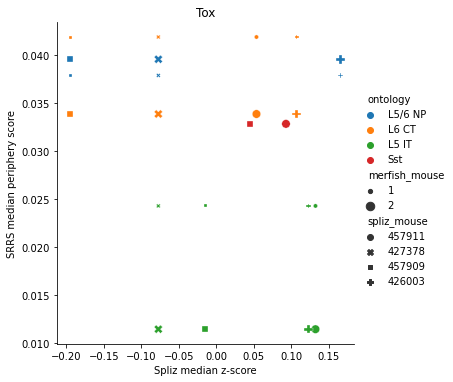

In [166]:
#none of the correlations are significant, but I'll plot all genes anyway

#all correlation data on single plot

#pdf = matplotlib.backends.backend_pdf.PdfPages("significant_srrs_10X_readzs_correlations_by_mouse.pdf")

for gene,g in gene_sample_ontology_df.groupby('gene'):
    g['spliz_mouse'] = g['mouse'].astype(str)
    hue_order = g.groupby('ontology')['median_scZ'].mean().sort_values().index
    
    sns.relplot(
        x = 'median_scZ',
        y = 'med_score',
        hue = 'ontology',
        size = 'merfish_mouse',
        style = 'spliz_mouse',
        hue_order = hue_order,
        data = g,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Spliz median z-score')
    plt.ylabel('SRRS median periphery score')
    plt.title('{}'.format(gene))
    plt.show()
    #pdf.savefig(bbox_inches='tight')
    plt.close()

#pdf.close()

# Results are that the SRRS values have very small dynamic range here

Is this surprising?

# Preprocessing to get gene/ontology effect sizes

In [2]:
spliz_paths = glob.glob('../outputs/spliz/*')
spliz_paths

['../outputs/spliz/BICCN_10x_457911_sym_SVD_normdonor_S_0.1_z_0.0_b_5_subcol.tsv',
 '../outputs/spliz/BICCN_10x_457911_pvals_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_427378_outdf_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_426003_pvals_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_457909_pvals_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_457911_outdf_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_426003_outdf_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_427378_pvals_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_457909_outdf_subclass_label-class_label_100_S_0.1_z_0.0_b_5.tsv',
 '../outputs/spliz/BICCN_10x_427378_sym_SVD_normdonor_S_0.1_z_0.0_b_5_subcol.tsv',
 '../outputs/spliz/BICCN_10x_457909_sym_SVD_normdonor_S_0.1_z_0.0_b_5_subc

In [66]:
#Set of all MERFISH genes (252)
merf_genes = set(pd.read_csv('../outputs/gene/Merfish_MOp_peripheral.csv')['gene'])
len(merf_genes)

252

In [133]:
#Calculate gene/ontology spliz effect sizes
subclass_df = pd.DataFrame()
for p in glob.glob('../outputs/spliz/*SVD*'):
    mouse = os.path.basename(p).split('_')[2]
    cell_df = pd.read_csv(p,sep='\t')
    
    #spliz genes can be strings of multiple genes separated by a comma
    cell_df['gene_list'] = cell_df['gene'].str.split(',')
    cell_df = cell_df[['gene_list','subclass_label','scZ','cell']].explode('gene_list')
    cell_df = cell_df.rename(columns={'gene_list':'gene','subclass_label':'ontology'})
    cell_df = cell_df[~cell_df['gene'].str.contains('unknown')]
    
    #Groupby gene/ontology and calculate median z-score
    agg_df = cell_df.groupby(['gene','ontology']).agg(
        median_scZ = ('scZ','median'),
        num_spliz_cells = ('cell','nunique'),
    ).reset_index()
    
    agg_df['mouse'] = mouse
    subclass_df = pd.concat((subclass_df,agg_df))
    
spliz_genes = set(subclass_df['gene'])

print('There are',len(spliz_genes),'unique genes in the Spliz dataset(s)')
print('There are',len(merf_genes.intersection(spliz_genes)),'shared genes between spliz and Merf')

There are 3844 unique genes in the Spliz dataset(s)
There are 41 shared genes between spliz and Merf


In [134]:
subclass_df

,gene,ontology,median_scZ,num_spliz_cells,mouse
0,0610010F05Rik,L2/3 IT,0.371945,7,457911
1,0610010F05Rik,L5 IT,0.290084,17,457911
2,0610010F05Rik,L6 CT,0.421531,11,457911
3,0610010F05Rik,L6 IT,0.371945,5,457911
4,0610010F05Rik,Pvalb,0.347543,2,457911
...,...,...,...,...,...
26961,n-THgtg6,Sst,-0.009283,1,426003
26962,n-THgtg9,L2/3 IT,-0.377964,3,426003
26963,n-THgtg9,L5 IT,-0.389428,4,426003
26964,n-THgtg9,L5/6 NP,-0.400892,1,426003


In [135]:
subclass_df[subclass_df['gene'].isin(merf_genes)]

,gene,ontology,median_scZ,num_spliz_cells,mouse
724,Ano4,L6 CT,1.024564,1,457911
725,Ano4,Oligo,-1.201436,1,457911
2224,Cbln2,L2/3 IT,0.037889,219,457911
2225,Cbln2,L5 IT,0.089692,254,457911
2226,Cbln2,L5/6 NP,0.065126,44,457911
...,...,...,...,...,...
26185,Wipf3,L2/3 IT,-0.653553,2,426003
26186,Wipf3,L5 IT,0.093333,2,426003
26187,Wipf3,L6 CT,0.263480,1,426003
26188,Wipf3,Low Quality,-0.653553,1,426003


In [136]:
subclass_df['ontology'].unique()

array(['L2/3 IT', 'L5 IT', 'L6 CT', 'L6 IT', 'Pvalb', 'Lamp5', 'L6b',
       'Sst', 'L5/6 NP', 'Low Quality', 'Sncg', 'Vip', 'doublet', 'L5 ET',
       'L6 IT Car3', 'Astro', 'Endo', 'Oligo', 'Macrophage', 'OPC',
       'VLMC', 'SMC'], dtype=object)

In [137]:
out_path = '../outputs/spliz/spliz_merf_genes_eff_sizes.csv'
subclass_df[
    (~subclass_df['ontology'].isin(['Low Quality','doublet'])) &
    subclass_df['gene'].isin(merf_genes)
].to_csv(out_path,index=False)

In [71]:
#The gtf used for Spliz has 239/252 of the MERFISH genes
rooz_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/Roozbeh/single_cell_project/SICILIAN_references/mouse/SICILIAN_mouse_mm10_Refs/gtf_file/GCF_000001635.26_GRCm38.p6_genomic.gtf',
    sep = '\t',
    comment = '#',
    header = None,
    names = ['chrom','source','kind','start','stop','dot1','strand','dot2','info'],
)
rooz_gtf = rooz_gtf[rooz_gtf['kind'].eq('gene')]
rooz_gtf['gene_name'] = rooz_gtf['info'].str.extract('gene_id "(.*?)";')

#The Spliz gtf has 239 of 252 Merfish genes present
print(len(merf_genes))
len(merf_genes.intersection(rooz_gtf['gene_name']))

252


239

In [97]:
#The genes in the spliz output are all found in the original GTF used in spliz as expected
spliz_genes.difference(rooz_gtf['gene_name'])

set()

# The pvals datasets don't have gene/subclass level p-values of effect sizes

In [3]:
pval_paths = glob.glob('../outputs/spliz/*pval*')
pval_df = pd.DataFrame()
for i,pval_path in enumerate(pval_paths):
    mouse_num = os.path.basename(pval_path).split('_')[2]
    mouse = 'Mouse_'+mouse_num
    sub_df = pd.read_csv(pval_path,sep='\t')
    sub_df['mouse'] = mouse
    pval_df = pd.concat((pval_df,sub_df))
    
pval_df

,gene,num_onts,grouping_level_1,chi2_pval_adj_scZ,perm_pval_adj_scZ,max_abs_median_scZ,perm_cdf_scZ,chi2_pval_adj_svd_z0,perm_pval_adj_svd_z0,max_abs_median_svd_z0,...,max_abs_median_svd_z1,perm_cdf_svd_z1,chi2_pval_adj_svd_z2,perm_pval_adj_svd_z2,max_abs_median_svd_z2,perm_cdf_svd_z2,f0,f1,f2,mouse
0,Ndufa5,6,Glutamatergic,5.389291e-03,0.0,0.083775,1.0,0.000000e+00,0.315798,3.379678,...,0.095273,NaN,0.053760,0.206772,0.145624,0.96,0.845279,0.134336,0.016357,Mouse_457911
1,Ptprd,6,Glutamatergic,2.636065e-05,0.0,0.216547,1.0,6.500863e-06,0.000000,1.758369,...,0.642003,1.00,1.000000,NaN,0.221156,NaN,0.218350,0.105991,0.060059,Mouse_457911
2,Ppp3ca,4,Glutamatergic,0.000000e+00,0.0,0.359524,1.0,2.452328e-09,0.507920,1.689068,...,0.124172,NaN,0.977639,NaN,0.238276,NaN,0.644985,0.151325,0.044542,Mouse_457911
3,Ppp2r2b,5,Glutamatergic,6.937147e-04,0.0,0.282422,1.0,1.000000e+00,NaN,0.460593,...,1.155854,0.93,1.000000,NaN,0.043079,NaN,0.596080,0.218051,0.075539,Mouse_457911
4,Dab1,3,Glutamatergic,1.047968e-07,0.0,0.525492,1.0,1.000000e+00,NaN,0.627513,...,0.532073,1.00,1.000000,NaN,0.211190,NaN,0.412594,0.308187,0.082209,Mouse_457911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,unknown_chr3_33100000,2,Glutamatergic,1.000000e+00,NaN,0.184958,NaN,1.000000e+00,NaN,0.727490,...,0.848629,NaN,1.000000,NaN,0.130599,NaN,0.381264,0.232296,0.129102,Mouse_427378
1917,unknown_chrM_0,4,Glutamatergic,1.000000e+00,NaN,0.329812,NaN,1.000000e+00,NaN,0.052157,...,0.029748,NaN,1.000000,NaN,0.055652,NaN,0.053950,0.036705,0.029733,Mouse_427378
1918,unknown_chrY_90700000,3,GABAergic,1.000000e+00,NaN,0.082037,NaN,1.000000e+00,NaN,0.882306,...,0.169095,NaN,1.000000,NaN,0.086756,NaN,0.126794,0.060151,0.046194,Mouse_427378
1919,unknown_chrY_90800000,3,GABAergic,1.000000e+00,NaN,0.145557,NaN,1.000000e+00,NaN,1.254424,...,0.367883,NaN,1.000000,NaN,0.168880,NaN,0.289838,0.134791,0.112774,Mouse_427378


In [4]:
pval_df['gene'].nunique()

1619

In [5]:
pval_df.groupby(['gene','mouse']).filter(lambda g: len(g) > 3).sort_values('gene').head().T

,296,293,294,295,274
gene,Akr1a1,Akr1a1,Akr1a1,Akr1a1,Atp5h
num_onts,2,4,7,2,6
grouping_level_1,Non-Neuronal,GABAergic,Glutamatergic,Low Quality,Glutamatergic
chi2_pval_adj_scZ,1,1,1,1,1
perm_pval_adj_scZ,NaN,NaN,NaN,NaN,NaN
max_abs_median_scZ,0.0585605,0.051525,0.0487899,0.0479437,0.0222247
perm_cdf_scZ,NaN,NaN,NaN,NaN,NaN
chi2_pval_adj_svd_z0,1,1,1,1,0
perm_pval_adj_svd_z0,NaN,NaN,NaN,NaN,0.128131
max_abs_median_svd_z0,1.81519,1.81519,1.81519,1.81519,1.45456


## Testing if Spliz effect sizes are correlated across mice for significant gene/group1 pairs

All pairs of mice are significantly correlated in their spliz effect size score with large positive pearson-r

,Mouse1,Mouse2,r,p
0,Mouse_426003,Mouse_427378,0.734974,3.317948e-07
1,Mouse_426003,Mouse_457909,0.819580,5.383147e-08
2,Mouse_426003,Mouse_457911,0.875113,2.948577e-12
3,Mouse_427378,Mouse_457909,0.775388,1.260149e-06
4,Mouse_427378,Mouse_457911,0.881653,1.244915e-12
5,Mouse_457909,Mouse_457911,0.958119,2.724250e-17


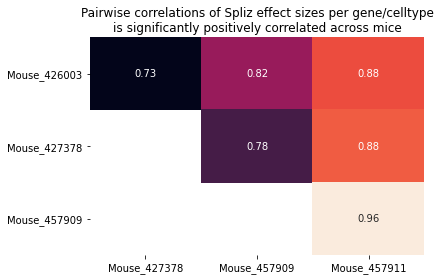

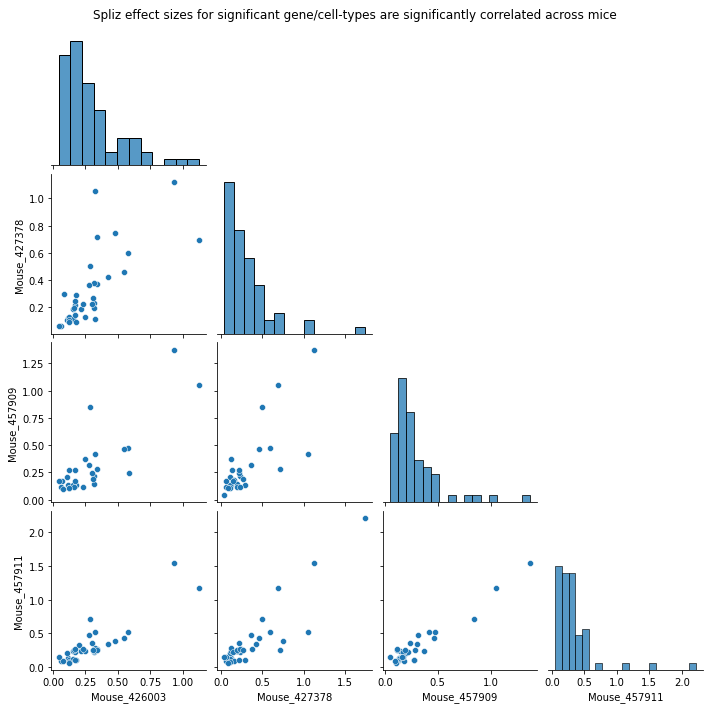

In [47]:
wide_df = pval_df[
    (~pval_df['gene'].str.contains('unknown')) & #limit to only annotated genes
    pval_df['perm_pval_adj_scZ'].le(0.05) #limit to only significant gene/ann/mouse groups
].pivot(
    index = ['gene','grouping_level_1'],
    columns = 'mouse',
    values = 'max_abs_median_scZ',
)

data = {
    'Mouse1':[],
    'Mouse2':[],
    'r':[],
    'p':[],
}
for m1,m2 in itertools.combinations(wide_df.columns,2):
    vals = wide_df[[m1,m2]].dropna().values
    v1,v2 = vals[:,0],vals[:,1]
    r,p = stats.pearsonr(v1,v2)
    data['Mouse1'].append(m1)
    data['Mouse2'].append(m2)
    data['r'].append(r)
    data['p'].append(p)
    
corr_df = pd.DataFrame(data)
display(corr_df)

hm_df = corr_df.pivot(
    index='Mouse1',
    columns='Mouse2',
    values='r',
)
sns.heatmap(hm_df,annot=True,cbar=False)
plt.title("""Pairwise correlations of Spliz effect sizes per gene/celltype
is significantly positively correlated across mice""")
plt.xlabel('')
plt.ylabel('')
plt.show()
plt.close()

sns.pairplot(
    wide_df,
    corner = True
)
plt.suptitle('Spliz effect sizes for significant gene/cell-types are significantly correlated across mice')
plt.show()
plt.close()

## Same analysis of Spliz correlation across mice, but for all gene/group_1 pairs

The correlations are still significant, but with less positive pearson-r values

,Mouse1,Mouse2,r,p
0,Mouse_426003,Mouse_427378,0.588846,3.658925e-172
1,Mouse_426003,Mouse_457909,0.595264,2.386475e-147
2,Mouse_426003,Mouse_457911,0.590832,3.293775e-162
3,Mouse_427378,Mouse_457909,0.542928,5.023398e-112
4,Mouse_427378,Mouse_457911,0.580376,6.025611e-142
5,Mouse_457909,Mouse_457911,0.640205,1.514878e-173


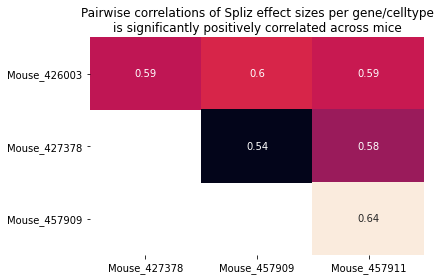

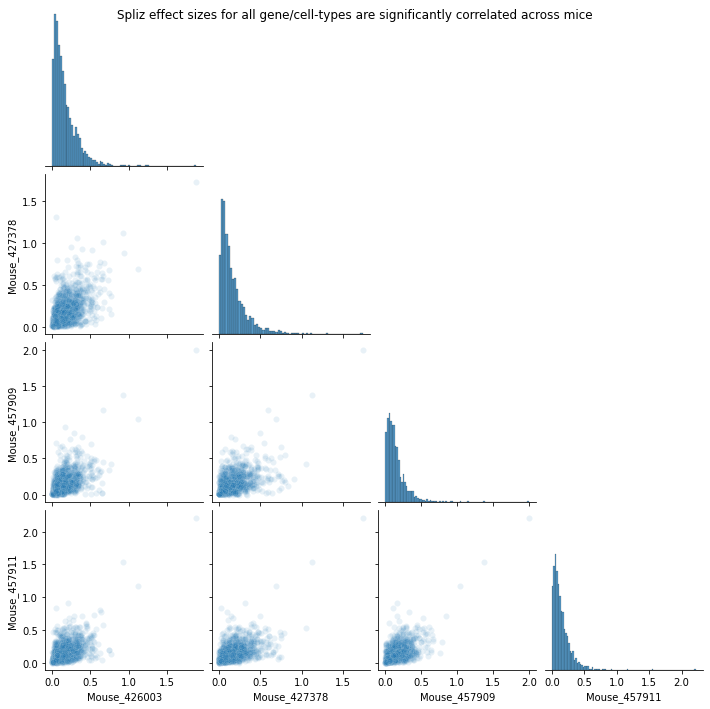

In [54]:
wide_df = pval_df[
    (~pval_df['gene'].str.contains('unknown')) #limit to only annotated genes
].pivot(
    index = ['gene','grouping_level_1'],
    columns = 'mouse',
    values = 'max_abs_median_scZ',
)

data = {
    'Mouse1':[],
    'Mouse2':[],
    'r':[],
    'p':[],
}
for m1,m2 in itertools.combinations(wide_df.columns,2):
    vals = wide_df[[m1,m2]].dropna().values
    v1,v2 = vals[:,0],vals[:,1]
    r,p = stats.pearsonr(v1,v2)
    data['Mouse1'].append(m1)
    data['Mouse2'].append(m2)
    data['r'].append(r)
    data['p'].append(p)
    
corr_df = pd.DataFrame(data)
display(corr_df)

hm_df = corr_df.pivot(
    index='Mouse1',
    columns='Mouse2',
    values='r',
)
sns.heatmap(hm_df,annot=True,cbar=False)
plt.title("""Pairwise correlations of Spliz effect sizes per gene/celltype
is significantly positively correlated across mice""")
plt.xlabel('')
plt.ylabel('')
plt.show()
plt.close()

sns.pairplot(
    wide_df,
    corner = True,
    plot_kws = {'alpha':0.1,},
)
plt.suptitle('Spliz effect sizes for all gene/cell-types are significantly correlated across mice')
plt.show()
plt.close()